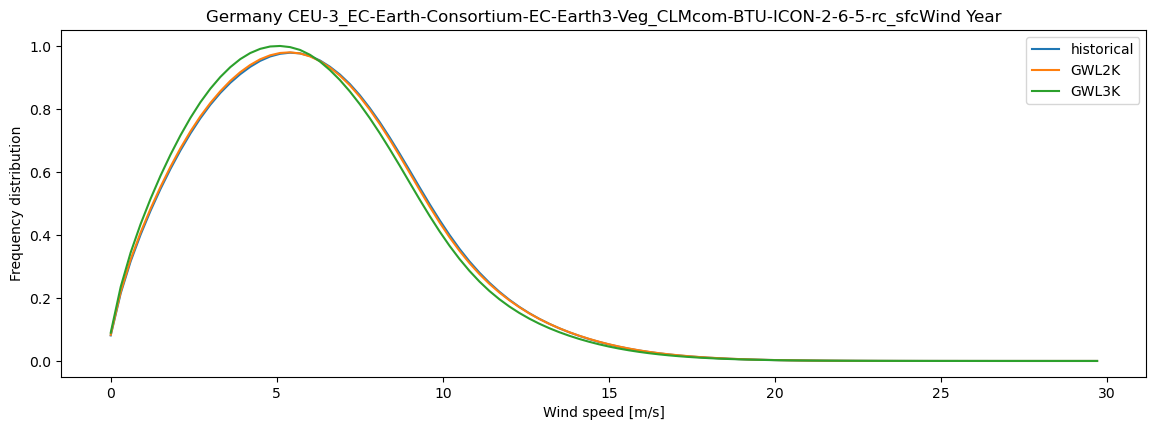

In [ ]:
# sfcWind speed histogram
import json

import matplotlib.pyplot as plt
import numpy as np

region = "Germany"
with open(f"sfcWind/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_sfcWind"
    Hereon_data = wind_stats[dataset]
    edges = wind_stats["edges"]
    wind_hist = Hereon_data["historical"]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]

    season = "Year"
    max_count = max(wind_hist[season]["counts"] + wind_2K[season]["counts"] + wind_3K[season]["counts"])
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(edges[:-1], np.array(data[season]["counts"]) / max_count, label=labels[index])
        #plt.stairs(data["counts"], edges,label=labels[index])
    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("Frequency distribution")
    plt.xlabel("Wind speed [m/s]")
    plt.legend()
    plt.show()

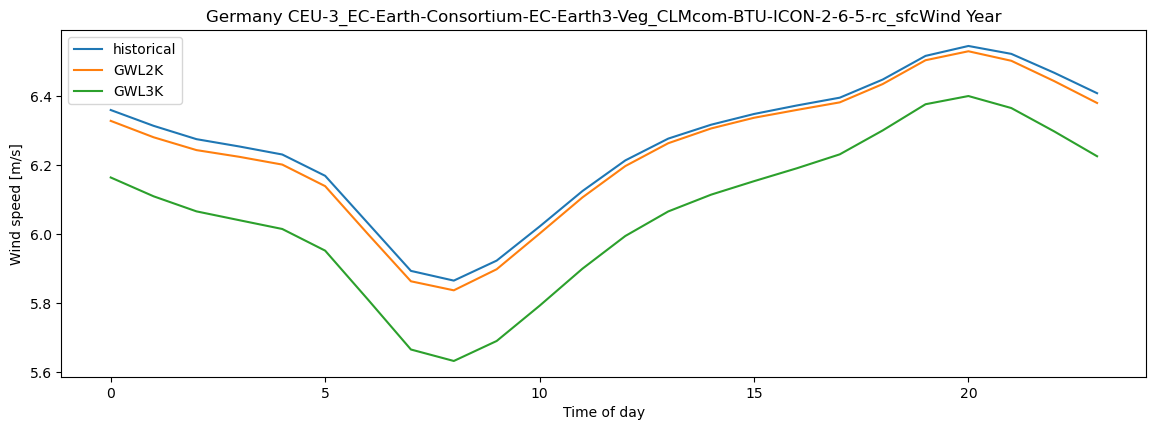

In [ ]:
# Wind speed daily cycle
import json
import matplotlib.pyplot as plt

region = "Germany"
with open(f"sfcWind/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_sfcWind"
    Hereon_data = wind_stats[dataset]
    wind_hist = Hereon_data["historical"]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]
    season = "Year"
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(data[season]["diurnal_cycle"], label=labels[index])

    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("Wind speed [m/s]")
    plt.xlabel("Time of day")
    plt.legend()
    plt.show()

In [3]:
import json
from collections import defaultdict

def latex_escape(s):
    return s.replace("_", "\\_")

# 1) Load data
with open("sfcWind/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

season = "Year"
entries = []

# 2) Flatten out (res, gcm, rcm, scenario, mean)
for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        if season in stats and "mean" in stats[season]:
            mean_val = stats[season]["mean"]
            entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))

# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5   # total columns in the tabular environment

lines = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\resizebox{1.2\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule"
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(len(s_list)
                    for rcm_dict in gcm_blocks.values()
                    for s_list in rcm_dict.values())
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\caption{Mean wind speed grouped by Resolution, GCM, RCM and Scenario}",
    "\\end{table}"
]

print("\n".join(lines))


\begin{table}[htbp]
\centering
\resizebox{1.2\linewidth}{!}{%
\begin{tabular}{lll|l|r}
\toprule
Resolution & GCM & RCM & Scenario & Value \\
\midrule
\multirow{22}{*}{CEU-3} & \multirow{10}{*}{EC-Earth-Consortium-EC-Earth3-Veg} & \multirow{7}{*}{CLMcom-BTU-ICON-2-6-5-rc} & historical & 6.26 \\
 &  &  & ssp245-GWL2K & 6.20 \\
 &  &  & ssp245-GWL3K & 6.12 \\
 &  &  & ssp370-GWL2K & 6.24 \\
 &  &  & ssp370-GWL3K & 6.06 \\
 &  &  & ssp585-GWL2K & 6.22 \\
 &  &  & ssp585-GWL3K & 6.18 \\
\cmidrule(lr){3-5}
 &  & \multirow{3}{*}{CLMcom-KIT-CCLM-6-0-clm2} & historical & 6.43 \\
 &  &  & ssp370-GWL2K & 6.43 \\
 &  &  & ssp370-GWL3K & 6.24 \\
\cmidrule(lr){3-5}
\cmidrule(lr){2-5}
 & \multirow{6}{*}{MIROC-MIROC6} & \multirow{3}{*}{CLMcom-BTU-ICON-2-6-5-rc} & historical & 5.94 \\
 &  &  & ssp370-GWL2K & 5.85 \\
 &  &  & ssp370-GWL3K & 5.79 \\
\cmidrule(lr){3-5}
 &  & \multirow{3}{*}{CLMcom-KIT-CCLM-6-0-clm2} & historical & 6.23 \\
 &  &  & ssp370-GWL2K & 6.14 \\
 &  &  & ssp370-GWL3K & 6.05 \\
\cm

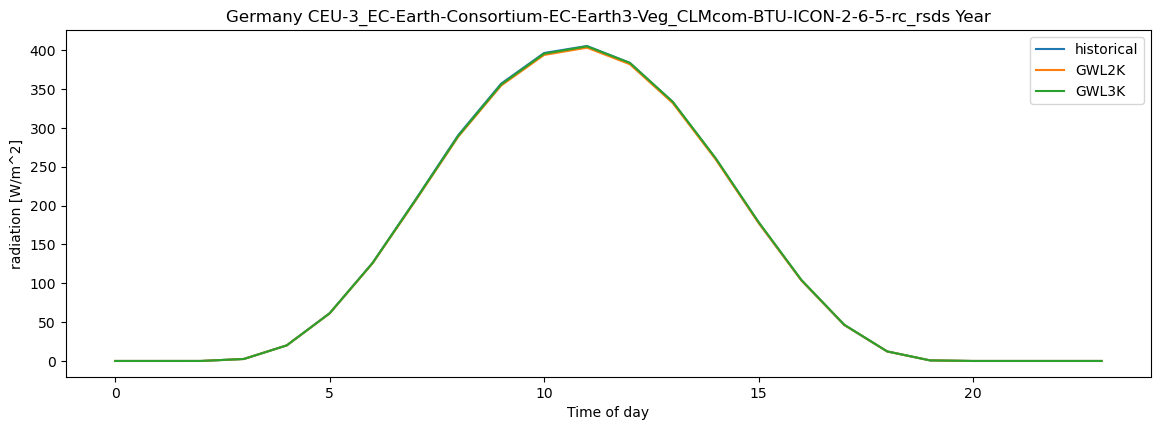

In [1]:
# PV daily cycle
import json
import matplotlib.pyplot as plt

region = "Germany"
with open(f"rsds/{region}.json", "r", encoding="utf-8") as file:
    wind_stats = json.load(file)
    dataset = "CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_rsds"
    Hereon_data = wind_stats[dataset]
    wind_2K = Hereon_data["ssp370-GWL2K"]
    wind_3K = Hereon_data["ssp370-GWL3K"]
    season = "Year"
    plt.figure(figsize=(14, 4.5))
    labels = ["historical", "GWL2K", "GWL3K"]
    wind_hist = Hereon_data["historical"]
    for index, data in enumerate([wind_hist, wind_2K, wind_3K]):
        plt.plot(data[season]["diurnal_cycle"], label=labels[index])

    plt.title(f"{region} {dataset} {season}")
    plt.ylabel("radiation [W/m^2]")
    plt.xlabel("Time of day")
    plt.legend()
    plt.show()

In [1]:
import json
from collections import defaultdict

def latex_escape(s):
    return s.replace("_", "\\_")

# 1) Load data
with open("rsds/Germany.json", encoding="utf-8") as f:
    wind_stats = json.load(f)

season = "Year"
entries = []

# 2) Flatten out (res, gcm, rcm, scenario, mean)
for ds_name, ds in wind_stats.items():
    if ds_name == "edges":
        continue

    res, gcm, rcm, *_ = ds_name.split("_")
    for scen, stats in ds.items():
        if season in stats and "mean" in stats[season]:
            mean_val = stats[season]["mean"]
            entries.append((res, gcm, rcm, scen, f"{mean_val:.2f}"))

# 3) Group by Resolution → GCM → RCM
grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for res, gcm, rcm, scen, val in entries:
    grouped[res][gcm][rcm].append((scen, val))

# 4) Build LaTeX
num_cols = 5   # total columns in the tabular environment

lines = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\resizebox{1.2\\linewidth}{!}{%",
    "\\begin{tabular}{lll|l|r}",
    "\\toprule",
    "Resolution & GCM & RCM & Scenario & Value \\\\",
    "\\midrule"
]

for res, gcm_blocks in grouped.items():
    # how many rows this resolution will span
    res_total = sum(len(s_list)
                    for rcm_dict in gcm_blocks.values()
                    for s_list in rcm_dict.values())
    res_mr = f"\\multirow{{{res_total}}}{{*}}{{{latex_escape(res)}}}"
    first_res = True

    # make a list so we know its length and can detect last
    gcm_items = list(gcm_blocks.items())
    for gi, (gcm, rcm_blocks) in enumerate(gcm_items):
        # how many rows this GCM will span
        gcm_total = sum(len(scen_list) for scen_list in rcm_blocks.values())
        gcm_mr = f"\\multirow{{{gcm_total}}}{{*}}{{{latex_escape(gcm)}}}"
        first_gcm = True

        for rcm, scenarios in rcm_blocks.items():
            rcm_mr = f"\\multirow{{{len(scenarios)}}}{{*}}{{{latex_escape(rcm)}}}"
            first_rcm = True

            for scen, val in scenarios:
                row = []
                # Resolution cell?
                if first_res:
                    row.append(res_mr)
                    first_res = False
                else:
                    row.append("")

                # GCM cell?
                if first_gcm:
                    row.append(gcm_mr)
                    first_gcm = False
                else:
                    row.append("")

                # RCM cell?
                if first_rcm:
                    row.append(rcm_mr)
                    first_rcm = False
                else:
                    row.append("")

                # Scenario + Value
                row.extend([latex_escape(scen), val])
                lines.append(" & ".join(row) + " \\\\")

            # after each RCM block, draw a partial rule from col 3 to the end
            lines.append(f"\\cmidrule(lr){{3-{num_cols}}}")

        # only draw the GCM‐level cmidrule if this isn’t the *last* GCM
        if gi < len(gcm_items) - 1:
            lines.append(f"\\cmidrule(lr){{2-{num_cols}}}")
        else:
            lines.pop()
    # after each Resolution block, draw a full midrule
    lines.append("\\midrule")

lines.pop()
lines += [
    "\\bottomrule",
    "\\end{tabular}",
    "}",
    "\\caption{Mean rsds grouped by Resolution, GCM, RCM and Scenario}",
    "\\end{table}"
]

print("\n".join(lines))


\begin{table}[htbp]
\centering
\resizebox{1.2\linewidth}{!}{%
\begin{tabular}{lll|l|r}
\toprule
Resolution & GCM & RCM & Scenario & Value \\
\midrule
\multirow{22}{*}{CEU-3} & \multirow{10}{*}{EC-Earth-Consortium-EC-Earth3-Veg} & \multirow{7}{*}{CLMcom-BTU-ICON-2-6-5-rc} & historical & 132.82 \\
 &  &  & ssp245-GWL2K & 132.95 \\
 &  &  & ssp245-GWL3K & 133.26 \\
 &  &  & ssp370-GWL2K & 132.16 \\
 &  &  & ssp370-GWL3K & 132.76 \\
 &  &  & ssp585-GWL2K & 132.68 \\
 &  &  & ssp585-GWL3K & 134.97 \\
\cmidrule(lr){3-5}
 &  & \multirow{3}{*}{CLMcom-KIT-CCLM-6-0-clm2} & historical & 128.93 \\
 &  &  & ssp370-GWL2K & 126.34 \\
 &  &  & ssp370-GWL3K & 127.39 \\
\cmidrule(lr){3-5}
\cmidrule(lr){2-5}
 & \multirow{6}{*}{MIROC-MIROC6} & \multirow{3}{*}{CLMcom-BTU-ICON-2-6-5-rc} & historical & 131.62 \\
 &  &  & ssp370-GWL2K & 132.91 \\
 &  &  & ssp370-GWL3K & 131.52 \\
\cmidrule(lr){3-5}
 &  & \multirow{3}{*}{CLMcom-KIT-CCLM-6-0-clm2} & historical & 128.38 \\
 &  &  & ssp370-GWL2K & 128.14 \\
 &  &

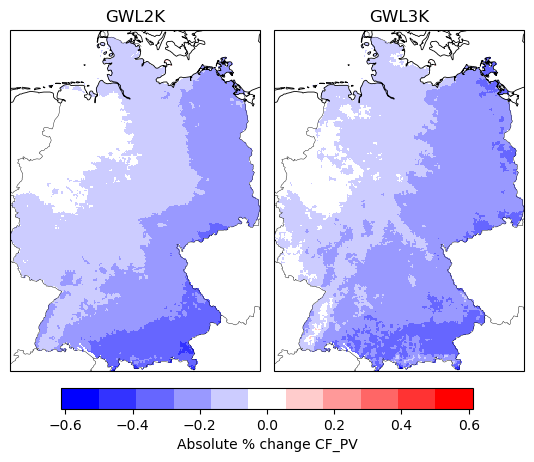

Mean value historical: 12.4599027633667%
Mean value GWL2K: 12.30844184756279%
Mean value GWL3K: 12.289425730705261%
Mean difference GWL2K: -0.1514645665884018%
Mean difference GWL3K: -0.170436292886734%


In [3]:
#Changes to CF_PV
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(pole_longitude=198.0, pole_latitude=39.25)  # Example values

fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 4.5),
    subplot_kw=dict(projection=rotated_pole),
    layout='compressed',
)


discrete_cmap = plt.get_cmap("bwr", 11)
discrete_cmap.set_bad(color=(0, 0, 0, 0))   

with open("CF_PV/Germany.json", "r", encoding="utf-8") as file:
    file_locations = json.load(file)
    data_location = file_locations["CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_PV"]
    file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
    file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
    file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

    GWL2K = file_2["CF_PV"].values - file_1["CF_PV"].values
    GWL3K = file_3["CF_PV"].values - file_1["CF_PV"].values

    v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
    v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
    if abs(v_min) > abs(v_max):
        v_max = abs(v_min)
    else:
        v_min = -v_max

    files = [GWL2K, GWL3K]
    scenarios = ["GWL2K", "GWL3K"]

    for ax, file, scenario in zip(axes, files, scenarios):
        cf_flaute = file * 100
        lat = file_1['lat'].values
        lon = file_1['lon'].values 

        cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))

        pm = ax.pcolormesh(lon, lat, cf_masked,
                           cmap=discrete_cmap, vmin=v_min, vmax=v_max,
                           shading='auto',
                           transform=ccrs.PlateCarree())  # Assuming lat/lon are in regular geographic coords

        ax.coastlines(linewidth=0.6)
        ax.add_feature(cfeature.BORDERS, linewidth=0.3)
        ax.set_title(scenario, fontsize=12)

    cbar = fig.colorbar(pm, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, shrink=0.8, label='Absolute % change CF_PV')
    plt.show()

    print(f"Mean value historical: {np.nanmean(file_1['CF_PV'].values)*100}%")
    print(f"Mean value GWL2K: {file_2['CF_PV'].mean().item()*100}%")
    print(f"Mean value GWL3K: {file_3['CF_PV'].mean().item()*100}%")
    print(f"Mean difference GWL2K: {np.nanmean(GWL2K)*100}%")
    print(f"Mean difference GWL3K: {np.nanmean(GWL3K)*100}%")


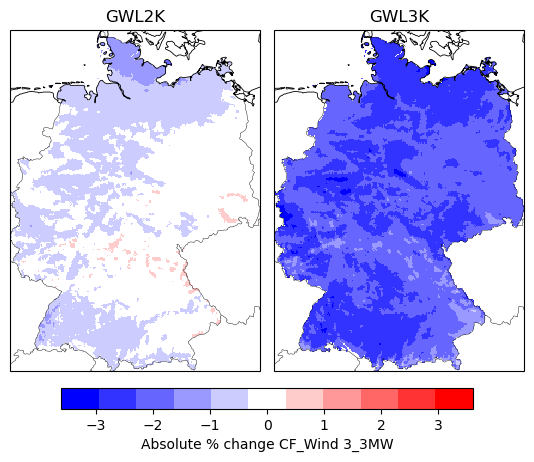

Mean value historical 3_3MW: 42.659889221191406%
Mean value GWL2K 3_3MW: 42.366498708724976%
Mean value GWL3K 3_3MW: 40.41682481765747%
Mean difference GWL2K 3_3MW: -0.29333558678627014%
Mean difference GWL3K 3_3MW: -2.243165969848633%


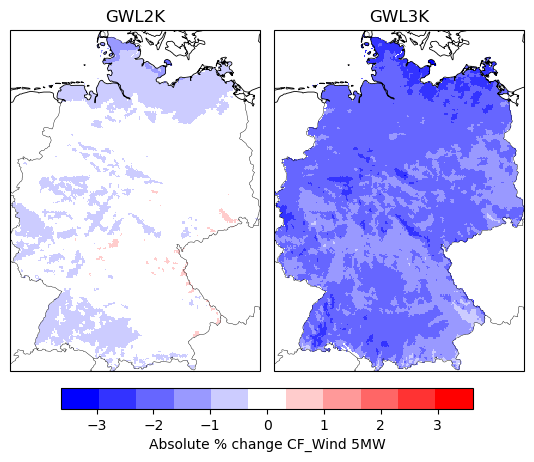

Mean value historical 5MW: 27.005088806152344%
Mean value GWL2K 5MW: 26.80658996105194%
Mean value GWL3K 5MW: 25.21321475505829%
Mean difference GWL2K 5MW: -0.1983807384967804%
Mean difference GWL3K 5MW: -1.7918963432312012%


In [4]:
#Changes to CF_Wind
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json

# Define rotated pole projection manually
rotated_pole = ccrs.RotatedPole(pole_longitude=198.0, pole_latitude=39.25)  # Example values


turbine_list=["3_3MW","5MW"]
for turbine in turbine_list:
    fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 4.5),
    subplot_kw=dict(projection=rotated_pole),
    layout='compressed',
)

    discrete_cmap = plt.get_cmap("bwr", 11)
    discrete_cmap.set_bad(color=(0, 0, 0, 0))   
    with open("CF_Wind/Germany.json", "r", encoding="utf-8") as file:
        file_locations = json.load(file)
        data_location = file_locations[turbine]["CEU-3_EC-Earth-Consortium-EC-Earth3-Veg_CLMcom-BTU-ICON-2-6-5-rc_CF_Wind"]
        file_1 = xr.open_dataset(data_location["historical"]["Year"]["timmean"])
        file_2 = xr.open_dataset(data_location["ssp370-GWL2K"]["Year"]["timmean"])
        file_3 = xr.open_dataset(data_location["ssp370-GWL3K"]["Year"]["timmean"])

        GWL2K = file_2["CF_Wind"].values - file_1["CF_Wind"].values
        GWL3K = file_3["CF_Wind"].values - file_1["CF_Wind"].values

        v_min = min(np.nanmin(GWL2K), np.nanmin(GWL3K)) * 100
        v_max = max(np.nanmax(GWL2K), np.nanmax(GWL3K)) * 100
        if abs(v_min) > abs(v_max):
            v_max = abs(v_min)
        else:
            v_min = -v_max

        files = [GWL2K, GWL3K]
        scenarios = ["GWL2K", "GWL3K"]

        for ax, file, scenario in zip(axes, files, scenarios):
            cf_flaute = file * 100
            lat = file_1['lat'].values
            lon = file_1['lon'].values 

            cf_masked = np.squeeze(np.ma.masked_equal(cf_flaute, 0))

            pm = ax.pcolormesh(lon, lat, cf_masked,
                            cmap=discrete_cmap, vmin=v_min, vmax=v_max,
                            shading='auto',
                            transform=ccrs.PlateCarree())  # Assuming lat/lon are in regular geographic coords

            ax.coastlines(linewidth=0.6)
            ax.add_feature(cfeature.BORDERS, linewidth=0.3)
            ax.set_title(scenario, fontsize=12)

        cbar = fig.colorbar(pm, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, shrink=0.8, label=f'Absolute % change CF_Wind {turbine}')
        plt.show()

        print(f"Mean value historical {turbine}: {np.nanmean(file_1['CF_Wind'].values)*100}%")
        print(f"Mean value GWL2K {turbine}: {file_2['CF_Wind'].mean().item()*100}%")
        print(f"Mean value GWL3K {turbine}: {file_3['CF_Wind'].mean().item()*100}%")
        print(f"Mean difference GWL2K {turbine}: {np.nanmean(GWL2K)*100}%")
        print(f"Mean difference GWL3K {turbine}: {np.nanmean(GWL3K)*100}%")


In [ ]:
# Changes to Dunkelflaute Germany (figure)

In [ ]:
# Changes to Dunkelflaute Germany (RCM/GCM table)

In [ ]:
# Changes to Dunkelflaute Germany (regions)